In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cyberbullying-dataset/twitter_sexism_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/youtube_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/kaggle_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/aggression_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/toxicity_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/attack_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv
/kaggle/input/cyberbullying-dataset/twitter_racism_parsed_dataset.csv


In [2]:
!pip install keras-vis     

  Obtaining dependency information for keras-vis from https://files.pythonhosted.org/packages/70/b6/585f1c100b3ee5b8a12cf603c21a9a1f11010eaf634b4d5d73346e7b0c14/keras_vis-0.4.1-py2.py3-none-any.whl.metadata


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

import re
import string
from wordcloud import WordCloud
from textblob import TextBlob

import nltk
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import word2vec
from collections import Counter
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.pipeline import Pipeline
import keras
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from tensorflow.keras.optimizers import Adam
import transformers
from transformers import (AutoTokenizer, 
                          AutoModelForSequenceClassification, 
                          TextClassificationPipeline)

import joblib
from tqdm import tqdm


import shap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
!pip install contractions
import contractions

  Obtaining dependency information for contractions from https://files.pythonhosted.org/packages/bb/e4/725241b788963b460ce0118bfd5c505dd3d1bdd020ee740f9f39044ed4a7/contractions-0.1.73-py2.py3-none-any.whl.metadata
  Obtaining dependency information for textsearch>=0.0.21 from https://files.pythonhosted.org/packages/e2/0f/6f08dd89e9d71380a369b1f5b6c97a32d62fc9cfacc1c5b8329505b9e495/textsearch-0.0.24-py2.py3-none-any.whl.metadata
  Obtaining dependency information for anyascii from https://files.pythonhosted.org/packages/4f/7b/a9a747e0632271d855da379532b05a62c58e979813814a57fa3b3afeb3a4/anyascii-0.3.2-py3-none-any.whl.metadata
  Obtaining dependency information for pyahocorasick from https://files.pythonhosted.org/packages/4d/22/61283c423676443dd2f96cf6b886b26f21db3c869ae73432bf00d128bec0/pyahocorasick-2.1.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_12_x86_64.manylinux2010_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 3.1 MB/s eta 0:0

In [5]:
data = pd.read_csv("/kaggle/input/cyberbullying-dataset/twitter_parsed_dataset.csv").drop(columns=['id', 'index', "Annotation"])
data.columns = ['text', 'label']
data.head(25)

,text,label
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0
1,@ShreyaBafna3 Now you idiots claim that people...,0.0
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0
4,#mkr No No No No No No,0.0
5,RT @TRobinsonNewEra: http://t.co/nkkCbpcHEo Sa...,0.0
6,RT @Millhouse66 @Maureen_JS nooo not sexist bu...,1.0
7,Going to make some pancakes.....Don't hve any ...,0.0
8,RT @ahtweet: @freebsdgirl How dare you have fe...,0.0
9,RT @Newmanzaa: There's something wrong when a ...,1.0


In [6]:
data['text'].sample(1).values[0]

'Downside of using @blocktogether is that I have to create a new twitter account for each block list.'

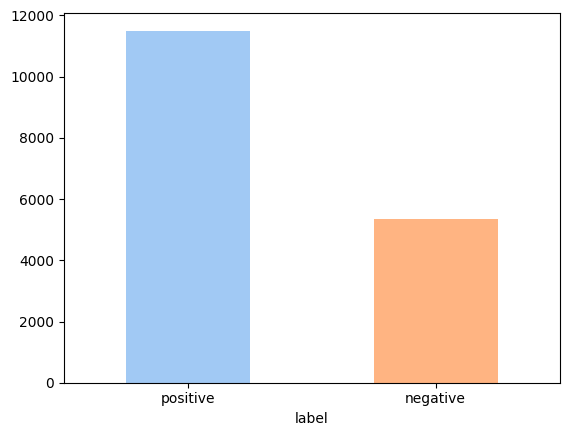

In [7]:
#Value counts for positive and negative tweets
data['label'].value_counts().plot(kind = 'bar', color = sns.color_palette('pastel'))
plt.xticks([0,1],['positive', 'negative'], rotation = 0);

In [8]:
#Cleaning text to contain only english 
only_english = set(nltk.corpus.words.words())
def clean_text(text):
    
    sample = text
    sample = " ".join([x.lower() for x in sample.split()])
    sample = re.sub(r"\S*https?:\S*", '', sample) #links and urls
    sample = re.sub('\[.*?\]', '', sample) #text between [square brackets]
    sample = re.sub('\(.*?\)', '', sample) #text between (parenthesis)
    sample = re.sub('#', ' ', sample) #remove hashtags
    sample = ' '.join([x for x in sample.split() if not x.startswith('@')]) # remove mentions with @
    sample = " ".join([contractions.fix(x) for x in sample.split()])  # fixes contractions like you're to you are
    sample = re.sub('[%s]' % re.escape(string.punctuation), ' ', sample) #punctuations
    sample = re.sub('\w*\d\w', '', sample)
    sample = re.sub(r'\n', ' ', sample) #new line character
    sample = re.sub(r'\\n', ' ', sample) #new line character
    sample = re.sub("[''""...“”‘’…]", '', sample) #list of quotation marks
    sample = " ".join(x.strip() for x in sample.split()) #strips whitespace
    sample = re.sub(r', /<[^>]+>/', '', sample)    #HTML attributes
    
    sample = ' '.join(list(filter(lambda ele: re.search("[a-zA-Z\s]+", ele) is not None, sample.split()))) #languages other than english
    
    sample = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE).sub(r'', sample) #emojis and symbols
    sample = sample.strip()
    sample = " ".join([x.strip() for x in sample.split()])
    return sample

In [9]:
#Checking for clean data
data['cleaned_text'] = data['text'].apply(lambda x: clean_text(str(x)))
data

,text,label,cleaned_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...
4,#mkr No No No No No No,0.0,mkr no no no no no no
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked


In [10]:
#Using stopword removal

stops = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

def get_wordnet_pos(word):
    
    treebank_tag = nltk.pos_tag([word])[0][1]
    
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def correct_text(text, stem=False, lemma=False, spell=False):
    if lemma and stem:
        raise Exception('Either stem or lemma can be true, not both!')
        return text
    
    sample = text
    
    #removing stopwords
    sample = sample.lower()
    sample = [word for word in sample.split() if not word in stops]
    sample = ' '.join(sample)
    
    if lemma:
        sample = sample.split()
        sample = [lemmatizer.lemmatize(word.lower(), get_wordnet_pos(word.lower())) for word in sample]
        sample = ' '.join(sample)
        
    if stem:
        sample = sample.split()
        sample = [ps.stem(word) for word in sample]
        sample = ' '.join(sample)
    
    if spell:
        sample = str(TextBlob(text).correct())
    return sample

In [11]:
#Checking data

data['correct_text'] = 'text'
data

,text,label,cleaned_text,correct_text
0,@halalflaws @biebervalue @greenlinerzjm I read...,0.0,i read them in context no change in meaning th...,text
1,@ShreyaBafna3 Now you idiots claim that people...,0.0,now you idiots claim that people who tried to ...,text
2,"RT @Mooseoftorment Call me sexist, but when I ...",1.0,rt call me sexist but when i go to an auto pla...,text
3,"@g0ssipsquirrelx Wrong, ISIS follows the examp...",1.0,wrong isis follows the example of mohammed and...,text
4,#mkr No No No No No No,0.0,mkr no no no no no no,text
...,...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",0.0,feeling so sorry for the girls they should be ...,text
16847,#MKR 'pretty good dishes we're happy with' - O...,0.0,mkr pretty good dishes we are happy with ok we...,text
16848,RT @colonelkickhead: Deconstructed lemon tart!...,0.0,rt deconstructed lemon tart can we please go j...,text
16849,@versacezaynx @nyazpolitics @greenlinerzjm You...,0.0,you are too stupid to talk to blocked,text


In [12]:
!unzip -o /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [13]:
from tqdm import tqdm
tqdm.pandas(desc ="my bar!")
column = 'text'
data[column] = data[column].progress_apply(lambda text: correct_text(str(text)))

my bar!: 100%|██████████| 16851/16851 [00:00<00:00, 142654.59it/s]


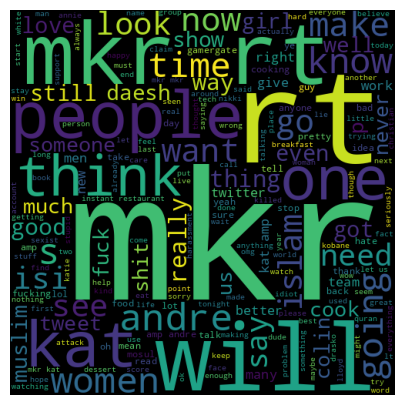

In [14]:
#Wordcloud Positive

filtered_data = data[data['label'] == 0]
g = ' '.join(filtered_data['cleaned_text'])
wordcloud = WordCloud(width = 500, height = 500, background_color = 'black', min_font_size = 10).generate(g)
plt.figure(figsize = (5, 5), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

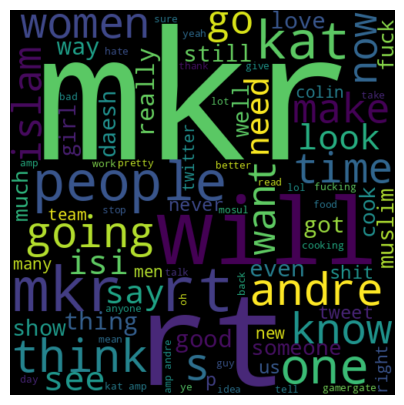

In [15]:
#WordCloud Negative

text_data = data[data['label'] == 0]['cleaned_text'].str.cat(sep=' ')
wordcloud = WordCloud(width = 500, height = 500, background_color = 'black', min_font_size = 10).generate(text_data)
plt.figure(figsize = (5, 5))
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis("off")
plt.show()

In [16]:
final_data = data.drop(columns = ['text', 'correct_text'])
final_data.to_csv("final_cleaned_data.csv", index = False)
final_data

,label,cleaned_text
0,0.0,i read them in context no change in meaning th...
1,0.0,now you idiots claim that people who tried to ...
2,1.0,rt call me sexist but when i go to an auto pla...
3,1.0,wrong isis follows the example of mohammed and...
4,0.0,mkr no no no no no no
...,...,...
16846,0.0,feeling so sorry for the girls they should be ...
16847,0.0,mkr pretty good dishes we are happy with ok we...
16848,0.0,rt deconstructed lemon tart can we please go j...
16849,0.0,you are too stupid to talk to blocked


In [17]:
from gensim.models import FastText
from nltk.tokenize import word_tokenize
from collections import Counter
import warnings

sentences_list = final_data['cleaned_text']
sentences_tokenized = [word_tokenize(sentence.lower()) for sentence in sentences_list]
warnings.filterwarnings('ignore')
fasttext_model = FastText(sentences = sentences_tokenized, min_count = 1)
fasttext_model.train(sentences_tokenized, epochs=25, total_examples=len(sentences_tokenized))
print(fasttext_model)

FastText<vocab=15985, vector_size=100, alpha=0.025>


In [18]:
vocab = Counter()
for sentence in sentences_tokenized:
    vocab.update(sentence)

In [19]:
# Saving vocabulary to a file
vocab_file = 'gensim_fasttext_vocab.txt'
lines = [word for word in vocab.keys()]
data = '\n'.join(lines)
with open(vocab_file, 'w', encoding="utf-8") as file:
    file.write(data)

In [20]:
print(vocab.most_common(50))

[('the', 7531), ('i', 6016), ('is', 5643), ('to', 5415), ('not', 5009), ('mkr', 4941), ('a', 4814), ('and', 4088), ('of', 3719), ('rt', 3683), ('you', 3592), ('that', 3176), ('are', 3006), ('it', 2918), ('in', 2647), ('but', 1912), ('for', 1875), ('have', 1771), ('they', 1747), ('do', 1722), ('am', 1643), ('on', 1534), ('this', 1456), ('be', 1372), ('can', 1230), ('with', 1156), ('just', 1108), ('sexist', 1088), ('kat', 1081), ('no', 1076), ('so', 1063), ('me', 1013), ('about', 1012), ('like', 1010), ('my', 996), ('was', 992), ('what', 990), ('all', 987), ('women', 969), ('islam', 925), ('your', 893), ('if', 886), ('will', 876), ('at', 801), ('as', 775), ('we', 775), ('s', 760), ('would', 747), ('people', 735), ('there', 720)]


In [21]:
from keras.models import Sequential
from keras.layers import GRU, Bidirectional, Dense, Dropout, Embedding, Layer, Concatenate
from keras import regularizers
import tensorflow as tf
from tensorflow.keras.layers import MultiHeadAttention

class CapsuleLayer(Layer):
    def __init__(self, num_capsule, dim_capsule, routings=3):
        super(CapsuleLayer, self).__init__()
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings

    def build(self, input_shape):
        # Initialize weight matrices for routing
        self.kernel = self.add_weight(
            shape=[input_shape[-1], self.num_capsule * self.dim_capsule],
            initializer='glorot_uniform',
            trainable=True,
        )

    def call(self, inputs):
        inputs_expand = tf.expand_dims(inputs, -2)  # Expand dims at the correct axis
        inputs_tiled = tf.tile(inputs_expand, [1, 1, self.num_capsule, 1])  # Tile correctly

        inputs_hat = tf.matmul(inputs_tiled, self.kernel)
        inputs_hat = tf.reshape(inputs_hat, [-1, inputs.shape[1], self.num_capsule, self.dim_capsule])

        b = tf.zeros_like(inputs_hat[:, :, :, 0])
        for i in range(self.routings):
            c = tf.nn.softmax(b, axis=2)  # Softmax along the correct axis
            outputs = self.squash(tf.reduce_sum(c[:, :, :, tf.newaxis] * inputs_hat, axis=2, keepdims=True))
            if i < self.routings - 1:
                b += tf.reduce_sum(inputs_hat * outputs, axis=-1)

        return tf.reshape(outputs, [-1, self.num_capsule * self.dim_capsule])

    def squash(self, s):
        squared_norm = tf.reduce_sum(tf.square(s), axis=-1, keepdims=True)
        scale = squared_norm / (1 + squared_norm) / tf.sqrt(squared_norm + tf.keras.backend.epsilon())
        return scale * s

In [22]:
from keras.models import Sequential
from keras.layers import Bidirectional, GRU, MultiHeadAttention, Dense, Dropout, Reshape, Input
from keras.models import Model  # Importing Model instead of Sequential


def create_model(hidden_units, num_classes): 
    input_layer = Input(shape=(32,))
    reshaped_input = Reshape((1, 32))(input_layer) 

    # Bidirectional GRU Layers
    bidir_gru = Bidirectional(GRU(hidden_units, return_sequences=True))(reshaped_input)
    query = Bidirectional(GRU(hidden_units, return_sequences=True))(bidir_gru)
    key = Bidirectional(GRU(hidden_units, return_sequences=True))(bidir_gru)
    value = Bidirectional(GRU(hidden_units, return_sequences=True))(bidir_gru)

    # MultiHeadAttention Layer
    attended_output = MultiHeadAttention(num_heads=8, key_dim=hidden_units)(query, key, value)
    attended_output = Dense(hidden_units, activation='relu')(attended_output)

    # Capsule Layer
    capsule_layer = CapsuleLayer(num_capsule=num_classes, dim_capsule=16, routings=3)(attended_output)

    # Dense Layers
    dropout_1 = Dropout(0.5)(capsule_layer)
    dense_1 = Dense(hidden_units, activation='relu')(dropout_1)
    dropout_2 = Dropout(0.5)(dense_1)
    dense_2 = Dense(hidden_units, activation='relu')(dropout_2)
    dropout_3 = Dropout(0.5)(dense_2)
    output = Dense(1, activation='sigmoid')(dropout_3)

    model = Model(inputs=input_layer, outputs=output)
    return model

In [23]:
X = final_data['cleaned_text']
y = final_data['label']

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.28, random_state = 42)

In [25]:
X_train.fillna(" ", axis = 0, inplace = True)
X_test.fillna(" ", axis = 0, inplace = True)
y_train.fillna(0.0, inplace = True)
y_test.fillna(1.0, inplace = True)

In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define or import the create_tokenizer function
def create_tokenizer(texts):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(texts)
    return tokenizer

tokenizer = create_tokenizer(X_train.values)

In [27]:
vocab_set = set([x for x in vocab if len(x) > 2])
tokenizer = create_tokenizer(X_train.values)
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(s.split()) for s in X_train])

In [28]:
from keras.preprocessing.sequence import pad_sequences

# Define or import the encode_docs function
def encode_docs(tokenizer, max_length, docs):
    # Tokenize the documents
    encoded_docs = tokenizer.texts_to_sequences(docs)
    
    # Pad sequences to a fixed length
    padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
    return padded_docs

In [29]:
from keras.utils import pad_sequences
x_train = encode_docs(tokenizer, max_length, X_train.values)
x_test = encode_docs(tokenizer, max_length, X_test.values)

In [30]:
print(x_train.shape)  
print(y_train.shape) 

(12132, 32)
(12132,)


In [31]:
print(x_test.shape)  
print(y_test.shape) 

(4719, 32)
(4719,)


In [32]:
hidden_units = 64  
model = create_model(hidden_units, x_train.shape[1])

In [33]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 32)]                 0         []                            
                                                                                                  
 reshape (Reshape)           (None, 1, 32)                0         ['input_1[0][0]']             
                                                                                                  
 bidirectional (Bidirection  (None, 1, 128)               37632     ['reshape[0][0]']             
 al)                                                                                              
                                                                                                  
 bidirectional_1 (Bidirecti  (None, 1, 128)               74496     ['bidirectional[0][0]']   

In [34]:
model.compile(loss = 'binary_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

In [35]:
epochs = 30
batch_size = 32

In [36]:
model.fit(x_train, y_train, batch_size = batch_size, epochs = epochs, validation_data = (x_test, y_test))

Epoch 1/30
380/380 [==============================] - 27s 24ms/step - loss: 0.6343 - accuracy: 0.6799 - val_loss: 0.6209 - val_accuracy: 0.6832
Epoch 2/30
380/380 [==============================] - 6s 17ms/step - loss: 0.6269 - accuracy: 0.6821 - val_loss: 0.6151 - val_accuracy: 0.6832
Epoch 3/30
380/380 [==============================] - 6s 17ms/step - loss: 0.6181 - accuracy: 0.6815 - val_loss: 0.6185 - val_accuracy: 0.6832
Epoch 4/30
380/380 [==============================] - 7s 17ms/step - loss: 0.6186 - accuracy: 0.6813 - val_loss: 0.6104 - val_accuracy: 0.6832
Epoch 5/30
380/380 [==============================] - 6s 17ms/step - loss: 0.6168 - accuracy: 0.6818 - val_loss: 0.6095 - val_accuracy: 0.6832
Epoch 6/30
380/380 [==============================] - 6s 17ms/step - loss: 0.6126 - accuracy: 0.6814 - val_loss: 0.6085 - val_accuracy: 0.6832
Epoch 7/30
380/380 [==============================] - 6s 17ms/step - loss: 0.6117 - accuracy: 0.6813 - val_loss: 0.6106 - val_accuracy: 0.683

In [37]:
model.evaluate(x_test,y_test)

148/148 [==============================] - 1s 6ms/step - loss: 0.6116 - accuracy: 0.6832


[0.6115565896034241, 0.6831955909729004]

In [38]:
from sklearn.metrics import confusion_matrix, classification_report

Y_pred = model.predict(x_test)
Y_pred = (Y_pred > 0.5)

print(confusion_matrix(y_test, Y_pred))
print(classification_report(y_test, Y_pred))

148/148 [==============================] - 3s 5ms/step
[[3224    0]
 [1495    0]]
              precision    recall  f1-score   support

         0.0       0.68      1.00      0.81      3224
         1.0       0.00      0.00      0.00      1495

    accuracy                           0.68      4719
   macro avg       0.34      0.50      0.41      4719
weighted avg       0.47      0.68      0.55      4719



In [39]:
train_loss, train_acc = model.evaluate(x_train, y_train, verbose = 2)
print('\nTrain Accuracy :', train_acc)
print('\nTrain Loss :', train_loss)

380/380 - 2s - loss: 0.5792 - accuracy: 0.6823 - 2s/epoch - 6ms/step

Train Accuracy : 0.6823277473449707

Train Loss : 0.5792247653007507


In [40]:
test_loss, test_acc = model.evaluate(x_test, y_test, verbose = 2)
print('\nTest Accuracy :', test_acc)
print('\nTest Loss :', test_loss)

148/148 - 1s - loss: 0.6116 - accuracy: 0.6832 - 842ms/epoch - 6ms/step

Test Accuracy : 0.6831955909729004

Test Loss : 0.6115565896034241


In [41]:
print(f"Bi-GAC Model\n")
print(f"Training Accuracy: {round(train_acc * 100, 4)}% \nTrain Loss: {round(train_loss, 4)}\n")
print(f"Testing Accuracy: {round(test_acc * 100, 4)}% \nTest Loss: {round(test_loss, 4)}")

Bi-GAC Model

Training Accuracy: 68.2328% 
Train Loss: 0.5792

Testing Accuracy: 68.3196% 
Test Loss: 0.6116


In [42]:
label_mapping = {0.0: "not cyberbullying", 1.0: "cyberbullying"}

# Predict the class for the input sample
input_to_predict = x_test[345]
input_to_predict = np.reshape(input_to_predict, (1, -1))
predicted_class = model.predict(input_to_predict)

# Actual Label using iloc for integer-based indexing
actual_label_numeric = y_test.iloc[350]
actual_label_name = label_mapping[actual_label_numeric]

# Predicted Label
predicted_label_numeric = np.argmax(predicted_class[0])  
predicted_label_name = label_mapping[predicted_label_numeric]

print(f"Actual label: {actual_label_name}")
print(f"Predicted label: {predicted_label_name}")

1/1 [==============================] - 0s 23ms/step
Actual label: not cyberbullying
Predicted label: not cyberbullying
